## Heart Rate Monitoring During Physical Exercise Using Wrist-Type Photoplethysmographic (PPG) Signals with Fedot.Industrial

The goal of this dataset is to estimate heart rate using PPG sensors. This dataset contains 3096, 5 dimensional time series obtained from the IEEE Signal Processing Cup 2015: Heart Rate Monitoring During Physical Exercise Using Wrist-Type Photoplethysmographic (PPG) Signals. Two-channel PPG signals, three-axis acceleration signals, and one-channel ECG signals were simultaneously recorded from subjects with age from 18 to 35. For each subject, the PPG signals were recorded from wrist by two pulse oximeters with green LEDs (wavelength: 515nm). Their distance (from center to center) was 2 cm. The acceleration signal was also recorded from wrist by a three-axis accelerometer. Both the pulse oximeter and the accelerometer were embedded in a wristband, which was comfortably worn. The ECG signal was recorded simultaneously from the chest using wet ECG sensors. All signals were sampled at 125 Hz and sent to a nearby computer via Bluetooth.
Link to the dataset - https://zenodo.org/record/3902710

In [2]:
import pandas as pd

from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.core.architecture.preprocessing.DatasetLoader import DataLoader
from fedot_ind.core.repository.initializer_industrial_models import IndustrialModels
from examples.example_utils import init_input_data, calculate_regression_metric

The list of basic fedot industrial models for experiment are shown below. We using simple linear machine learning pipelines with 3 different feature generators: Statistical, Reccurence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [3]:
model_dict = {
    'regression_with_statistical_features': PipelineBuilder().add_node('quantile_extractor',
                                                                       params={'window_size': 10}).add_node('ridge'),
    'regression_pca_with_statistical_features': PipelineBuilder().add_node('quantile_extractor',
                                                                           params={'window_size': 10}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_with_reccurence_features': PipelineBuilder().add_node('recurrence_extractor',
                                                                           params={'window_size': 20}).add_node('ridge'),
    'regression_pca_with_reccurence_features': PipelineBuilder().add_node('recurrence_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_with_topological_features': PipelineBuilder().add_node('topological_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_pca_with_topological_features': PipelineBuilder().add_node('topological_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge')
}
metric_dict = {}
dataset_name = 'IEEEPPG'
data_path = PROJECT_PATH + '/examples/data'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [4]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2023-10-05 14:57:11,110 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/IEEEPPG


In [5]:
input_data = init_input_data(train_data[0], train_data[1], task='regression')

Lets check our data.

In [6]:
input_data.features.shape

(1768, 5, 1000)

Lets visualise our predictors.

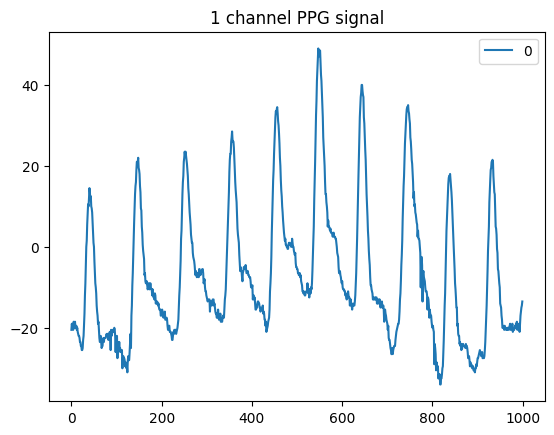

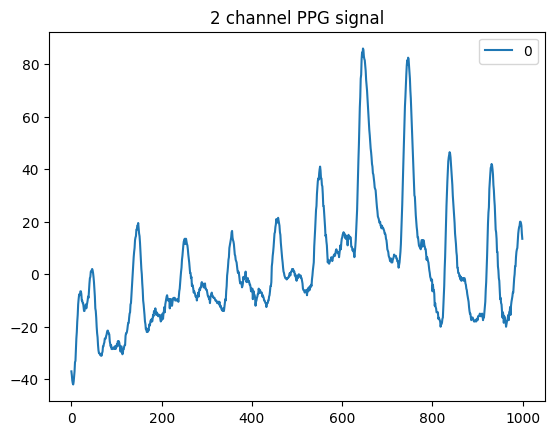

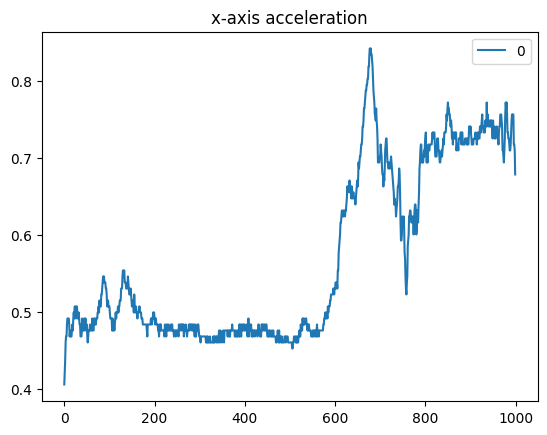

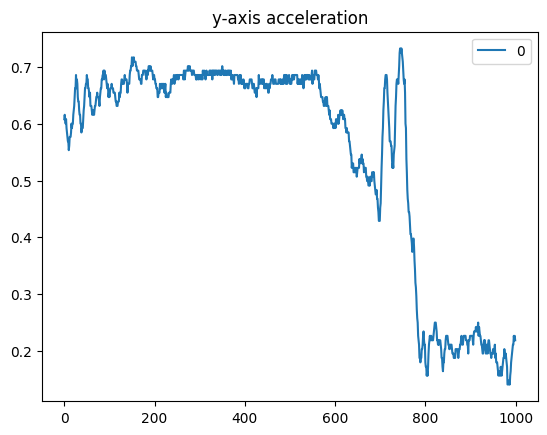

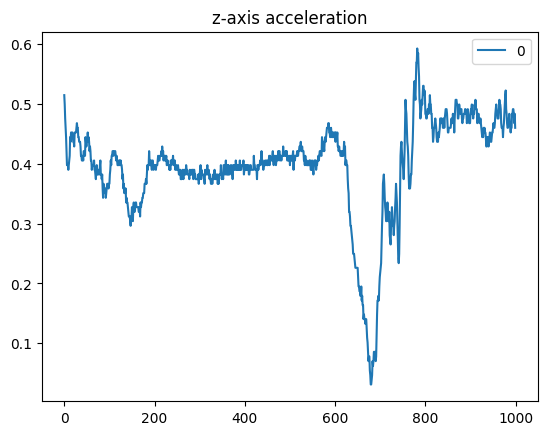

In [7]:
from matplotlib import pyplot as plt
pd.DataFrame(input_data.features[1, 0, :]).plot(title='1 channel PPG signal')
pd.DataFrame(input_data.features[1, 1, :]).plot(title='2 channel PPG signal')
pd.DataFrame(input_data.features[1, 2, :]).plot(title='x-axis acceleration')
pd.DataFrame(input_data.features[1, 3, :]).plot(title='y-axis acceleration')
pd.DataFrame(input_data.features[1, 4, :]).plot(title='z-axis acceleration')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [8]:
input_data = init_input_data(train_data[0], train_data[1], task='regression')
val_data = init_input_data(test_data[0], test_data[1], task='regression')
with IndustrialModels():
    for model in model_dict.keys():
        print(f'Current_model - {model}')
        pipeline = model_dict[model].build()
        pipeline.fit(input_data)
        features = pipeline.predict(val_data).predict
        metric = calculate_regression_metric(test_target=test_data[1], labels=features)
        metric_dict.update({model: metric})

Current_model - regression_with_statistical_features
Current_model - regression_pca_with_statistical_features


KeyboardInterrupt: 

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [ ]:
print(metric_dict)